# Prerequisites

In [4]:
import sys, os
import numpy as np

import torch
import torch.nn as nn

import pandas as pd
import json
import collections

import matplotlib.pyplot as plt
from tqdm.auto import tqdm

import html # for HTML entities
from bs4 import BeautifulSoup
import re # in order to preprocess unwanted characters

from gensim.models import Word2Vec

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet 
 
lemmatizer = WordNetLemmatizer()

from sklearn import utils

In [5]:
SEED = 28

torch.manual_seed(SEED)

In [6]:
%load_ext autoreload
%autoreload 2

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [7]:
data_tain_path = './dataset/train_set.csv'
data_test_path = './dataset/test_set.csv'
batch_size = 4

# 1. Dataset Analysis

Let's see how the training dataset is distributed:

In [10]:
pandas_dataset_train = pd.read_csv(data_tain_path)
pandas_dataset_test = pd.read_csv(data_test_path)

In [12]:
pandas_dataset_train

,Job_offer,Label
0,"Openjobmetis SpA ricerca, per importante azien...",Java Developer
1,"La persona prescelta, diplomata o laureata in ...",Software Engineer
2,Sei un informatico o matematico con la passion...,Software Engineer
3,"Ti occuperai della progettazione, realizzazion...",Programmer
4,Stiamo cercando uno\una sviluppatore\sviluppat...,Programmer
...,...,...
1747,"* Test JUnit\n * Git, La Ibs Srl è alla ri...",Java Developer
1748,"La ricorsa, inserita all'interno di un team, l...",Programmer
1749,Sviluppatore Java Junior da inserire in attivi...,Java Developer
1750,La risorsa sarà inserita nei team di risorse d...,Web Developer


In [13]:
pandas_dataset_test

,Job_offer,Label
0,Siamo alla ricerca di figure di Full Stack Dev...,Web Developer
1,"Nell'ambito del potenziamento della struttura,...",Java Developer
2,"* Gestione dell'infrastruttura informatica, de...",System Analyst
3,La risorsa è il responsabile dell'installazion...,System Analyst
4,"La risorsa, inserita nell'area Innovation Cent...",Java Developer
...,...,...
434,"Ali SpA filiale di Fano, cerca per Azienda di ...",System Analyst
435,Job summary Parola chiave: digitalizzazione! U...,Web Developer
436,Job summary Parola chiave: digitalizzazione! U...,Web Developer
437,Unazienda che offre servizi a 360°: alle grand...,Web Developer


In [14]:
def plot_dataset_distribution(pandas_dataset, title = "labels distribution"):
    fig, ax = plt.subplots()
    fig.suptitle(title, fontsize=12)
    pandas_dataset["Label"].reset_index().groupby("Label").count().sort_values(by="index").plot(kind="barh", legend=False, ax=ax).grid(axis='x')
    plt.show()

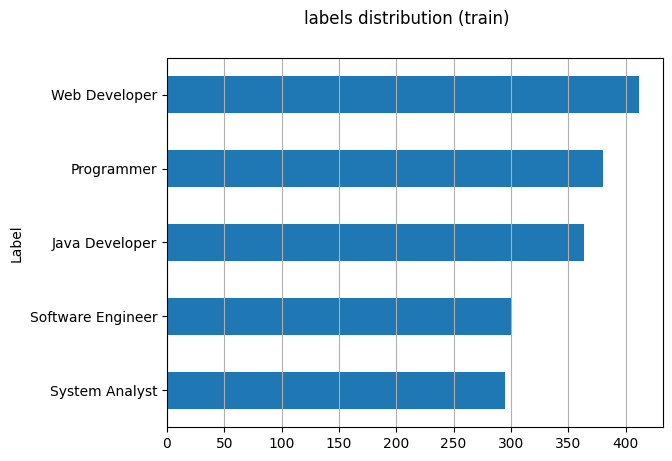

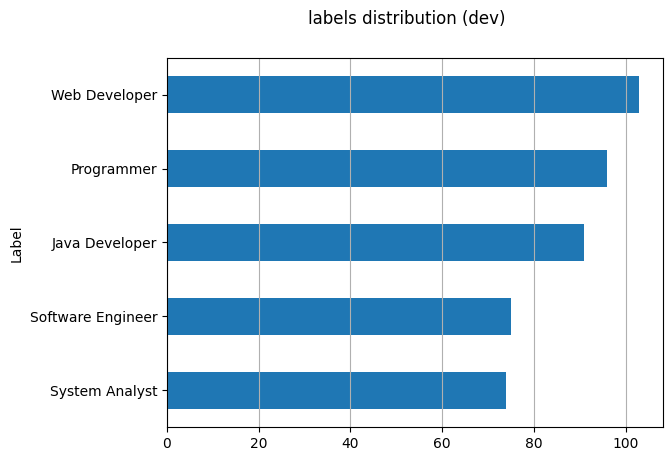

In [16]:
plot_dataset_distribution(pandas_dataset_train, "labels distribution (train)")
plot_dataset_distribution(pandas_dataset_test, "labels distribution (dev)")

In [22]:
label2index = {v:i for i,v in enumerate(sorted(pandas_dataset_train.Label.unique().tolist()))}
label2index

{'Java Developer': 0,
 'Programmer': 1,
 'Software Engineer': 2,
 'System Analyst': 3,
 'Web Developer': 4}

In [23]:
index2label = {i:v for i,v in enumerate(sorted(pandas_dataset_test.Label.unique().tolist()))}
index2label

{0: 'Java Developer',
 1: 'Programmer',
 2: 'Software Engineer',
 3: 'System Analyst',
 4: 'Web Developer'}

# 2. Text preprocessing

In [36]:
text_rows_to_see = [0, 3, 5]

def print_problematic_text_rows(pd_data):
    for i in text_rows_to_see:
        print(pd_data.Job_offer[i], '\n')

In [37]:
print_problematic_text_rows(pandas_dataset_train)

Openjobmetis SpA ricerca, per importante azienda multinazionale leader nel settore sanitario e ospedaliero, un Software Developer. La risorsa, all'interno del team di R&D, si occuperà dello sviluppo, modellazione e manutenzione dei software e dei servizi per il sistema sanitario. Si interfaccerà inoltre con tutte le aree funzionali convolte dalla progettazione, sino allo sviluppo e manutenzione dei prodotti. Requisiti richiesti: - Laurea in Ingegneria Informatica, Matematica, Fisica o equipollenti; - Esperienza di sviluppo in Java (2-3 anni); - Esperienza di sviluppo su database relazionali e conoscenza SQL - conoscenza su soluzioni software Object Oriented e sui Design Pattern; - Buona conoscenza dell'inglese; Costituiscono titoli preferenziali ma non obbligatori: - Conoscenza di RDBMS Oracle, SQL e linguaggio PL/SQL; - Conoscenza di Javascript; - Esperienza di sviluppo con strumenti di middleware 

Ti occuperai della progettazione, realizzazione e manutenzione di siti web, servizi e 

In [38]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /home/marco/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [41]:
def preprocess_sentence(sentence: str, stopwords_list = stopwords.words('english')):
    sentence = re.sub(r' (#[0-9]+;)', r'&\1', sentence) # adding '&' to entities so that they can be converted as html entities
    sentence = html.unescape(sentence) # converting entities to characters
    # sentence = BeautifulSoup(sentence, "lxml").text # removing html tags
    sentence = re.sub(r'[^\w\s]', ' ', sentence.lower()) # clean (convert to lowercase and remove punctuations and characters)
    sentence = re.sub(r'( )[0-9]+', ' ', sentence) # removing numbers
    sentence = re.sub(r'[^a-z][a-z][^a-z]', ' ', sentence.strip()) # remove one-letter words (and then strip)
    # sentence = re.sub(' +', ' ', sentence) # removing possible additional spaces
    sentence = sentence.split() # tokenize (convert from string to list)
    if stopwords_list is not None: # removing stopwords
        sentence = [word for word in sentence if word not in stopwords_list]
    # stemming/lemming
    # sentence = [lemmatizer.lemmatize(word, wordnet.VERB) for word in sentence] # stemming/lemming doesn't help with this exercise
    sentence = " ".join(sentence) # return back to string
    return sentence

def preprocess_data(pd_dataset):
    for i, row in pd_dataset.iterrows():
        sentence = row['Job_offer']
        sentence = preprocess_sentence(sentence)
        pd_dataset.at[i,'Job_offer'] = sentence
    return

In [42]:
preprocess_data(pandas_dataset_train)

In [43]:
print_problematic_text_rows(pandas_dataset_train)

openjobmetis spa ricerca per importante azienda multinazionale leader nel settore sanitario ospedaliero un software developer la risorsa interno del team di si occuperà dello sviluppo modellazione manutenzione dei software dei servizi per il sistema sanitario si interfaccerà inoltre con tutte le aree funzionali convolte dalla progettazione sino allo sviluppo manutenzione dei prodotti requisiti richiesti laurea ingegneria informatica matematica fisica equipollenti esperienza di sviluppo java anni esperienza di sviluppo su database relazionali conoscenza sql conoscenza su soluzioni software object oriented sui design pattern buona conoscenza dell inglese costituiscono titoli preferenziali non obbligatori conoscenza di rdbms oracle sql linguaggio pl sql conoscenza di javascript esperienza di sviluppo con strumenti di middleware 

ti occuperai della progettazione realizzazione manutenzione di siti web servizi di api sarai il responsabile della nuova area webdev del gruppo ti occuperai di a

In [44]:
preprocess_data(pandas_dataset_test)

# 3. The model Word2Vec

<div style='text-align: center;'>
    <img src="https://www.researchgate.net/profile/Dima-Suleiman/publication/332543231/figure/fig1/AS:749763205009408@1555768886449/CBOW-and-Skip-gram-models-architecture-6.png" width="800"><br />
    <span>Word2Vec representation</span>
</div>

The gensim's Word2Vec implementation that will be used is the Skip-gram one.

In [55]:
def split_id_X_y(pd_dataset):
    return  [s.split(' ') for s in pd_dataset.Job_offer.to_numpy()], pd_dataset.Label.to_numpy() if 'Label' in pd_dataset.columns else None

In [56]:
X_train, y_train = split_id_X_y(pandas_dataset_train)

In [57]:
X_test, y_test = split_id_X_y(pandas_dataset_test)

In [58]:
X_train[:4]

[['openjobmetis',
  'spa',
  'ricerca',
  'per',
  'importante',
  'azienda',
  'multinazionale',
  'leader',
  'nel',
  'settore',
  'sanitario',
  'ospedaliero',
  'un',
  'software',
  'developer',
  'la',
  'risorsa',
  'interno',
  'del',
  'team',
  'di',
  'si',
  'occuperà',
  'dello',
  'sviluppo',
  'modellazione',
  'manutenzione',
  'dei',
  'software',
  'dei',
  'servizi',
  'per',
  'il',
  'sistema',
  'sanitario',
  'si',
  'interfaccerà',
  'inoltre',
  'con',
  'tutte',
  'le',
  'aree',
  'funzionali',
  'convolte',
  'dalla',
  'progettazione',
  'sino',
  'allo',
  'sviluppo',
  'manutenzione',
  'dei',
  'prodotti',
  'requisiti',
  'richiesti',
  'laurea',
  'ingegneria',
  'informatica',
  'matematica',
  'fisica',
  'equipollenti',
  'esperienza',
  'di',
  'sviluppo',
  'java',
  'anni',
  'esperienza',
  'di',
  'sviluppo',
  'su',
  'database',
  'relazionali',
  'conoscenza',
  'sql',
  'conoscenza',
  'su',
  'soluzioni',
  'software',
  'object',
  'orie

In [59]:
HS_PARAM = 1 # 0 = default = no hyerarchical sampling
NEG_PARAM = 0 # 5 = default = if >0 then negative sampling is used
# sg = 0 is CBOW

w2v_model = Word2Vec(X_train, vector_size=400, window=11, min_count=1, sg=1, hs=HS_PARAM, negative=NEG_PARAM, seed=SEED)

In [60]:
w2v_model.wv.key_to_index

{'di': 0,
 'per': 1,
 'la': 2,
 'con': 3,
 'il': 4,
 'del': 5,
 'un': 6,
 'team': 7,
 'sviluppo': 8,
 'che': 9,
 'le': 10,
 'dei': 11,
 'software': 12,
 'al': 13,
 'delle': 14,
 'alla': 15,
 'è': 16,
 'una': 17,
 'da': 18,
 'si': 19,
 'lavoro': 20,
 'della': 21,
 'dell': 22,
 'ti': 23,
 'web': 24,
 'su': 25,
 'conoscenza': 26,
 'nel': 27,
 'esperienza': 28,
 'ricerca': 29,
 'azienda': 30,
 'progetti': 31,
 'non': 32,
 'ai': 33,
 'soluzioni': 34,
 'parte': 35,
 'ed': 36,
 'attività': 37,
 'nella': 38,
 'gestione': 39,
 'risorsa': 40,
 'developer': 41,
 'sistemi': 42,
 'ectm': 43,
 'interno': 44,
 'occuperà': 45,
 'java': 46,
 'cliente': 47,
 'capacità': 48,
 'uno': 49,
 'più': 50,
 'nelle': 51,
 'servizi': 52,
 'progettazione': 53,
 'se': 54,
 'quali': 55,
 'competenze': 56,
 'programmatore': 57,
 'clienti': 58,
 'dati': 59,
 'tecnologie': 60,
 'sono': 61,
 'nell': 62,
 'sviluppare': 63,
 'applicazioni': 64,
 'requisiti': 65,
 'formazione': 66,
 'sarà': 67,
 'tue': 68,
 'analisi': 69,
 

In [61]:
w2v_model.wv.index_to_key

['di',
 'per',
 'la',
 'con',
 'il',
 'del',
 'un',
 'team',
 'sviluppo',
 'che',
 'le',
 'dei',
 'software',
 'al',
 'delle',
 'alla',
 'è',
 'una',
 'da',
 'si',
 'lavoro',
 'della',
 'dell',
 'ti',
 'web',
 'su',
 'conoscenza',
 'nel',
 'esperienza',
 'ricerca',
 'azienda',
 'progetti',
 'non',
 'ai',
 'soluzioni',
 'parte',
 'ed',
 'attività',
 'nella',
 'gestione',
 'risorsa',
 'developer',
 'sistemi',
 'ectm',
 'interno',
 'occuperà',
 'java',
 'cliente',
 'capacità',
 'uno',
 'più',
 'nelle',
 'servizi',
 'progettazione',
 'se',
 'quali',
 'competenze',
 'programmatore',
 'clienti',
 'dati',
 'tecnologie',
 'sono',
 'nell',
 'sviluppare',
 'applicazioni',
 'requisiti',
 'formazione',
 'sarà',
 'tue',
 'analisi',
 'tua',
 'come',
 'settore',
 'alle',
 'ambito',
 'principali',
 'te',
 'insieme',
 'nostro',
 'ad',
 'nuove',
 'squadra',
 'varie',
 'cerchiamo',
 'qui',
 'realtà',
 'anche',
 'innovative',
 'degli',
 'candidato',
 'end',
 'programmazione',
 'manutenzione',
 'progettare

# Visualize words

In [66]:
import random
from sklearn.decomposition import PCA
def plot_some_data(n_points = 30):
    # colors = ["black","tab:red", "tab:blue", "tab:green", "tab:orange", "tab:pink", "tab:cyan", "tab:gray", "tab:purple", "tab:olive"]
    # pick some words to visualise
    # words = random.sample(cbow_model.wv.index_to_key, n_points)
    words = ['java', 'c', 'azienda']
    
    # retrieve the trained embeddings
    coords = [w2v_model.wv[word] for word in words]
    

    # perform PCA to reduce our Nd embeddings to 2d points that can be plotted
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(coords) # .t() transpose the embeddings
    
    for i,(x,y) in enumerate(pca_result):
        plt.plot(x, y, 'ro')
        plt.text(x, y, words[i], fontsize=12) # add a point label, shifted wrt to the point
    plt.title('PCA on W2V')
    plt.show()

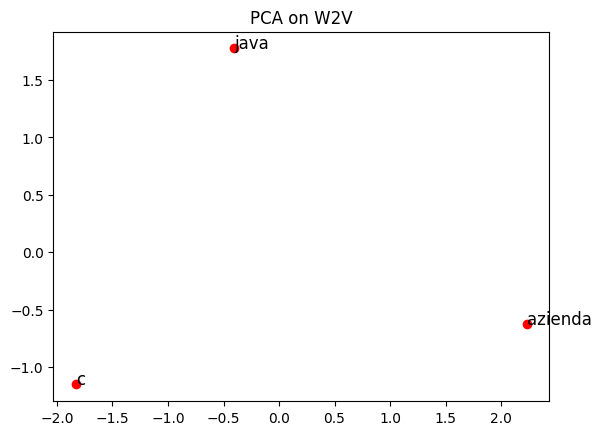

In [67]:
plot_some_data(n_points = 10)

# 4. Using the trained model for prediction

It will be used also the frequency of the word to give more weight on words that appeared less

In [68]:
def X_y_for_classifier(X_in, y_in):
    X_data_classifier, y_data_classifier = [], []
    for sentence, label in zip(X_in, y_in):
        words = [w for w in sentence if w in w2v_model.wv.key_to_index]
        
        freqs = [[w2v_model.wv.get_vecattr(w, "count")] for w in words]
        tot_freq = np.sum(freqs)
        freqs_normalized = 1 - np.divide( freqs , tot_freq )
        
        vectors = w2v_model.wv[words] * freqs_normalized
        
        result_vector = np.mean(vectors, axis=0)
        X_data_classifier.append( result_vector.tolist() )
        y_data_classifier.append( label )
    return X_data_classifier, y_data_classifier

def X_for_classifier(X_in):
    X_data_classifier = []
    for sentence in X_in:
        words = [w for w in sentence if w in w2v_model.wv.key_to_index]
        
        freqs = [[w2v_model.wv.get_vecattr(w, "count")] for w in words]
        tot_freq = np.sum(freqs)
        freqs_normalized = 1 - np.divide( freqs , tot_freq )
        
        vectors = w2v_model.wv[words] * freqs_normalized
        
        result_vector = np.mean(vectors, axis=0)
        X_data_classifier.append( result_vector.tolist() )
    return X_data_classifier

In [69]:
X_train_classifier, y_train_classifier = X_y_for_classifier(X_train, y_train)

In [74]:
X_test_classifier, y_test_classifier = X_y_for_classifier(X_test, y_test)

# Tuning (commented out so to prevent multiple times execution when training)

In [33]:
n_estimators = np.arange(100, 2000, step=100)
max_depth = list(np.arange(100, 200, step=10)) + [None]
min_samples_split = np.arange(2, 10, step=2)
min_samples_leaf = [1, 2, 4]
criterion = ["gini","entropy"]
max_features = ["auto", "sqrt", "log2"]
bootstrap = [True, False]

param_dict = {
    "n_estimators": n_estimators,
    "criterion": criterion,
    "max_features": max_features,
    "max_depth": max_depth,
    "min_samples_split": min_samples_split,
    "min_samples_leaf": min_samples_leaf,
    "bootstrap": bootstrap,
}
param_dict

{'n_estimators': array([ 100,  200,  300,  400,  500,  600,  700,  800,  900, 1000, 1100,
        1200, 1300, 1400, 1500, 1600, 1700, 1800, 1900]),
 'criterion': ['gini', 'entropy'],
 'max_features': ['auto', 'sqrt', 'log2'],
 'max_depth': [100, 110, 120, 130, 140, 150, 160, 170, 180, 190, None],
 'min_samples_split': array([2, 4, 6, 8]),
 'min_samples_leaf': [1, 2, 4],
 'bootstrap': [True, False]}

In [34]:
from sklearn.model_selection import RandomizedSearchCV

# random_cv = RandomizedSearchCV(RandomForestClassifier(random_state=SEED), param_dict, n_iter=100, cv=3, scoring="r2", n_jobs=-1)

In [35]:
# y_dev_classifier_indexes = [label2index[label] for label in y_dev_classifier]

In [36]:
# %%time

# _ = random_cv.fit(X_dev_classifier, y_dev_classifier_indexes)

In [37]:
# print("Best params:","\n",random_cv.best_params_)

The model was executed for 5 hours to find the best params using the dev set in order to reduce time. The best result was:<br/>
{'n_estimators': 1800, 'min_samples_split': 6, 'min_samples_leaf': 1, 'max_features': 'auto', 'max_depth': 100, 'criterion': 'entropy', 'bootstrap': False} <br/>
The problem is that it requires too much time for training it

# Final model

In [38]:
# from sklearn.ensemble import RandomForestClassifier

# fmodel = RandomForestClassifier(n_estimators=100, min_samples_split=6, min_samples_leaf=1, max_features='auto', max_depth=None, criterion='entropy', bootstrap=False,random_state=SEED)
# fmodel.fit(X_train_classifier, y_train_classifier)

In [39]:
# y_dev_classifier_pred = fmodel.predict(X_dev_classifier)

In [40]:
# from sklearn.metrics import classification_report

# print(classification_report(y_dev_classifier_pred, y_dev_classifier, target_names=fmodel.classes_))

The Random Forest Classifier did at best 75% of accuracy, but a NN could do maybe better, so I tried it:

In [72]:
from sklearn.neural_network import MLPClassifier

fmodel = MLPClassifier(hidden_layer_sizes=(100,), activation='relu', solver='sgd', 
                       alpha=0.0001, batch_size='auto', learning_rate='constant', 
                       learning_rate_init=0.001, power_t=0.5, max_iter=8000, shuffle=True, 
                       random_state=SEED, tol=0.0001, verbose=True, warm_start=False, 
                       momentum=0.9, nesterovs_momentum=True, early_stopping=False, validation_fraction=0.2, 
                       beta_1=0.9, beta_2=0.999, epsilon=1e-08, n_iter_no_change=10, max_fun=15000)
fmodel.fit(X_train_classifier, y_train_classifier)

Iteration 1, loss = 1.62019042
Iteration 2, loss = 1.61859209
Iteration 3, loss = 1.61656048
Iteration 4, loss = 1.61437311
Iteration 5, loss = 1.61222547
Iteration 6, loss = 1.61021333
Iteration 7, loss = 1.60838165
Iteration 8, loss = 1.60659412
Iteration 9, loss = 1.60496081
Iteration 10, loss = 1.60337661
Iteration 11, loss = 1.60188284
Iteration 12, loss = 1.60048536
Iteration 13, loss = 1.59908680
Iteration 14, loss = 1.59783970
Iteration 15, loss = 1.59660238
Iteration 16, loss = 1.59538419
Iteration 17, loss = 1.59422003
Iteration 18, loss = 1.59309373
Iteration 19, loss = 1.59200645
Iteration 20, loss = 1.59094676
Iteration 21, loss = 1.58987530
Iteration 22, loss = 1.58889872
Iteration 23, loss = 1.58787480
Iteration 24, loss = 1.58693523
Iteration 25, loss = 1.58594183
Iteration 26, loss = 1.58499657
Iteration 27, loss = 1.58407721
Iteration 28, loss = 1.58316391
Iteration 29, loss = 1.58226090
Iteration 30, loss = 1.58138230
Iteration 31, loss = 1.58050891
Iteration 32, los

MLPClassifier(max_iter=8000, random_state=28, solver='sgd',
              validation_fraction=0.2, verbose=True)

In [75]:
y_test_classifier_pred = fmodel.predict(X_test_classifier)

In [77]:
from sklearn.metrics import classification_report

print(classification_report(y_test_classifier_pred, X_test_classifier, target_names=fmodel.classes_))

ValueError: Classification metrics can't handle a mix of multiclass and continuous-multioutput targets

In [44]:
import pickle

with open(os.path.join(root_output, 'nn_model.pkl'),'wb') as f:
    pickle.dump(fmodel, f)

# Saving the results in the files

In [45]:
with open(os.path.join(root_output, 'predictions_dev.tsv'), 'w') as tsvfile:
    for i, label in enumerate(y_dev_classifier_pred):
        id_number = id_dev[i]
        print ("%s\t%s" % (id_number, label), file=tsvfile)

In [46]:
X_test_classifier = X_for_classifier(X_test)

In [47]:
y_test_classifier_pred = fmodel.predict(X_test_classifier)

In [48]:
with open(os.path.join(root_output, 'predictions_test.tsv'), 'w') as tsvfile:
    for i, label in enumerate(y_test_classifier_pred):
        id_number = id_test[i]
        print ("%s\t%s" % (id_number, label), file=tsvfile)

In [49]:
evaluate_model(os.path.join(root_output, 'predictions_dev.tsv'))

{'err_rate': '21.41'}
